In [2]:
!pip install tensorflow opencv-python sklearn matplotlib mediapipe


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

In [4]:
!pip install pyttsx3


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [50]:
import pyttsx3
engine = pyttsx3.init()
engine.say("jaffer is gay")
engine.runAndWait()

In [3]:
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

In [4]:
def mediapipe_det(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    results = model.process(image)
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image, results

In [30]:
def draw_stlyed_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION,
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1),
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1))
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4),
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2))
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4),
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2))
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4),
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2))

In [159]:
cap = cv2.VideoCapture(0)
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        ret, frame = cap.read()

        image, results = mediapipe_det(frame, holistic)
        #print(results)
        
        draw_stlyed_landmarks(image, results)
        cv2.imshow("frame", image)
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

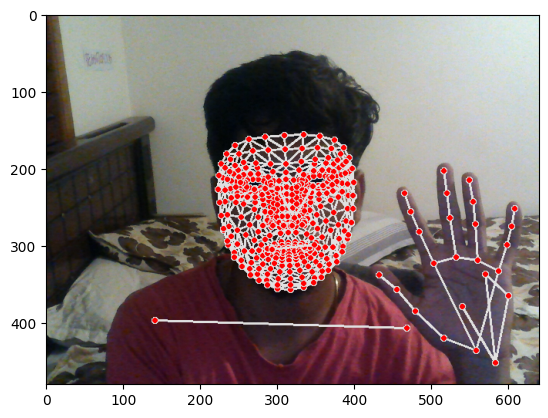

In [162]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

In [5]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(132)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

In [48]:
DATA_PATH = os.path.join('MP_Data2')
actions = np.array(['how', 'help you', 'you'])
no_sequences = 30
sequence_length = 30

In [49]:
for action in actions:
    for sequence in range(no_sequences):
        try:
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass
        

In [45]:

cap = cv2.VideoCapture(0)
time.sleep(4)
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    for action in actions:
        for sequence in range(no_sequences):
            for frame_num in range(sequence_length):
                
                ret, frame = cap.read()

                image, results = mediapipe_det(frame, holistic)
                #print(results)

                draw_stlyed_landmarks(image, results)
                
                if frame_num == 0:
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0),2,cv2.LINE_AA)
                    cv2.putText(image, f'Collecting frames for {action} video number: {sequence}', (15,12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255),1,cv2.LINE_AA)
                    cv2.waitKey(1000)

                else:
                    cv2.putText(image, f'Collecting frames for {action} video number: {sequence}', (15,12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255),1,cv2.LINE_AA)
                    
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)
                
                
                cv2.imshow("frame", image)
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break



KeyboardInterrupt: 

In [46]:
    cap.release()
    cv2.destroyAllWindows()

In [58]:
!pip install -U scikit-learn scipy matplotlib

In [7]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [8]:
label_map = {label:num for num, label in enumerate(actions)}

In [9]:
label_map

{'how are you': 0, 'nice to meet you': 1}

In [10]:
sequences, labels = [], []
for action in actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), f"{frame_num}.npy"))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [11]:
np.array(sequences).shape

(60, 30, 1662)

In [12]:
X = np.array(sequences)

In [13]:
X.shape

(60, 30, 1662)

In [14]:
y = to_categorical(labels).astype(int)

In [115]:
y

array([[1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1]])

In [15]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

In [55]:
y_test.shape

(5, 3)

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [17]:
log_dir = os.path.join("Logs")
tb_callback = TensorBoard(log_dir=log_dir)

In [18]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [19]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [47]:
model.fit(x_train, y_train, epochs=2000, callbacks=[tb_callback])

Epoch 1/2000
2/2 [==============================] - 1s 334ms/step - loss: 0.6687 - categorical_accuracy: 0.6667
Epoch 2/2000
2/2 [==============================] - 1s 329ms/step - loss: 0.6734 - categorical_accuracy: 0.4912
Epoch 3/2000
2/2 [==============================] - 1s 341ms/step - loss: 0.6737 - categorical_accuracy: 0.4912
Epoch 4/2000
2/2 [==============================] - 1s 310ms/step - loss: 0.6536 - categorical_accuracy: 0.7544
Epoch 5/2000
2/2 [==============================] - 1s 295ms/step - loss: 0.6727 - categorical_accuracy: 0.5263
Epoch 6/2000
2/2 [==============================] - 1s 310ms/step - loss: 0.6748 - categorical_accuracy: 0.5263
Epoch 7/2000
2/2 [==============================] - 1s 298ms/step - loss: 0.6577 - categorical_accuracy: 0.8421
Epoch 8/2000
2/2 [==============================] - 1s 309ms/step - loss: 0.6610 - categorical_accuracy: 0.5789
Epoch 9/2000
2/2 [==============================] - 1s 286ms/step - loss: 0.6576 - categorical_accuracy:

KeyboardInterrupt: 

In [40]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 64)            442112    
                                                                 
 lstm_1 (LSTM)               (None, 30, 128)           98816     
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 3)                 99        
                                                                 
Total params: 596,675
Trainable params: 596,675
Non-trai

In [18]:
model.load_weights('action1.h5')

In [21]:
res = model.predict(x_test)

1/1 [==============================] - 0s 336ms/step


In [22]:
actions[np.argmax(res[3])]

IndexError: index 3 is out of bounds for axis 0 with size 3

In [88]:
actions[np.argmax(y_test[3])]

'how are you'

In [101]:
model.save('action1.h5')

In [23]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [24]:
yhat = model.predict(x_test)

1/1 [==============================] - 0s 23ms/step


In [25]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [26]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[0, 2],
        [0, 1]],

       [[1, 0],
        [2, 0]]], dtype=int64)

In [27]:
accuracy_score(ytrue, yhat)

0.3333333333333333

In [28]:
def speak(s):
    engine.say(s)
    engine.runAndWait()

In [31]:
sequence = []
sentence = []
predictions = []
threshold = 0.9
qq=0

cap = cv2.VideoCapture(0)
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        ret, frame = cap.read()

        image, results = mediapipe_det(frame, holistic)
        #print(results)
        
        draw_stlyed_landmarks(image, results)
        
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            #print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            if np.unique(predictions[-10:])[0]==np.argmax(res):
                if res[np.argmax(res)] > threshold:
                    
                    if len(sentence) > 0:
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])
            if len(sentence) > 5:
                sentence = sentence[-5:]
        
        cv2.rectangle(image, (0,0), (640,40), (245,117,16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255),2,cv2.LINE_AA)   
        try:
            if qq!=len(sentence):
                speak(sentence[-1])
                qq+=1
                
        except:
            pass
        cv2.imshow("frame", image)
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 20ms/step


In [49]:
    cap.release()
    cv2.destroyAllWindows()

In [47]:
qq

5